Time Series = Trend + Seasonality + Residual

#### What is Trend?
- A positive trend is a line that generally slopes up. The value increases with time.
- A negative trend is a line that generally slopes down. The value decreases with time.

#### What is Seasonality?
- A seasonal time series has patterns that repeat at regular intervals. For example: high sales every weekend.

#### What is Cyclicality?
- A time series has repeating pattern but no fixed period.

#### What is White Noise?
- A series of measurements where each value is uncorrelated with previous values. For example: Flipping a coin. The outcone of a coin flip doesn't rely on the outcomes of the coin flips that came before. Similarly, with white noise, the series value doesn't depend on the values that came before.

#### What is Stationarity?
To model a time series, it must be stationary.
- Stationary means that the distribution of the data doesn't change with time.
- For a time series to be a stationary it must fulfill three criteria:
1. **Trend Stationarity:** The series should have zero trend. It is not growing or shrinking
2. **Variance is constant:** The average distance of the data points from the zero line isn't changing
3. **Autocorrelation is constant**


In [411]:
# Import modules
import pandas as pd
import numpy as np

# Import augmented dicky-fuller test function
#pip install statsmodel
from statsmodels.tsa.stattools import adfuller

# ARMA and SARIMAX models
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_absolute_error

# to save the model
import joblib

# time-series data visualization
import matplotlib.pyplot as plt
import seaborn as sns #pip install seaborn
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# to remove unnecessary warnings
import warnings

warnings.filterwarnings('ignore')

sns.set_context('talk')

#### Reading the data

In [412]:
input_data = 'earthquakes.csv'
output_data = 'earthquakes_predictions.csv'

In [413]:
# Load in the time series
df = pd.read_csv(input_data)

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.drop('Year', axis=1)

display(df.tail())
display(df.info())

,earthquakes_per_year
date,
1994-01-01,15.0
1995-01-01,25.0
1996-01-01,22.0
1997-01-01,20.0
1998-01-01,16.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 1900-01-01 to 1998-01-01
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   earthquakes_per_year  99 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


None

The given dataset has 99 rows and 1 feature. There's no missing value in this dataset.

Let's check the data, it's trend, season and residuals

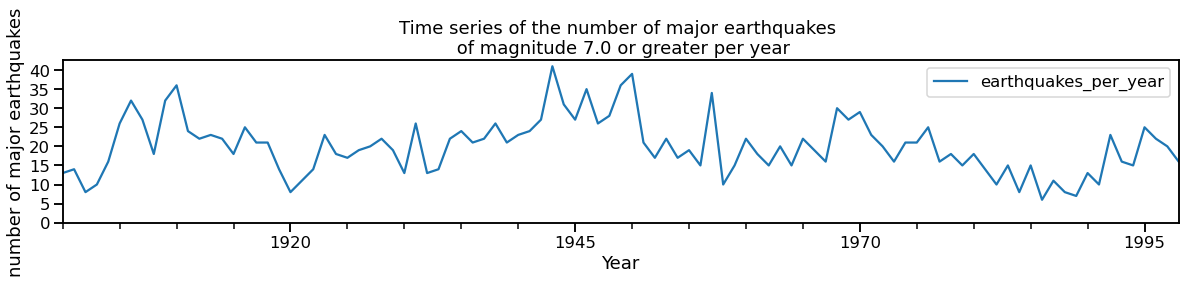

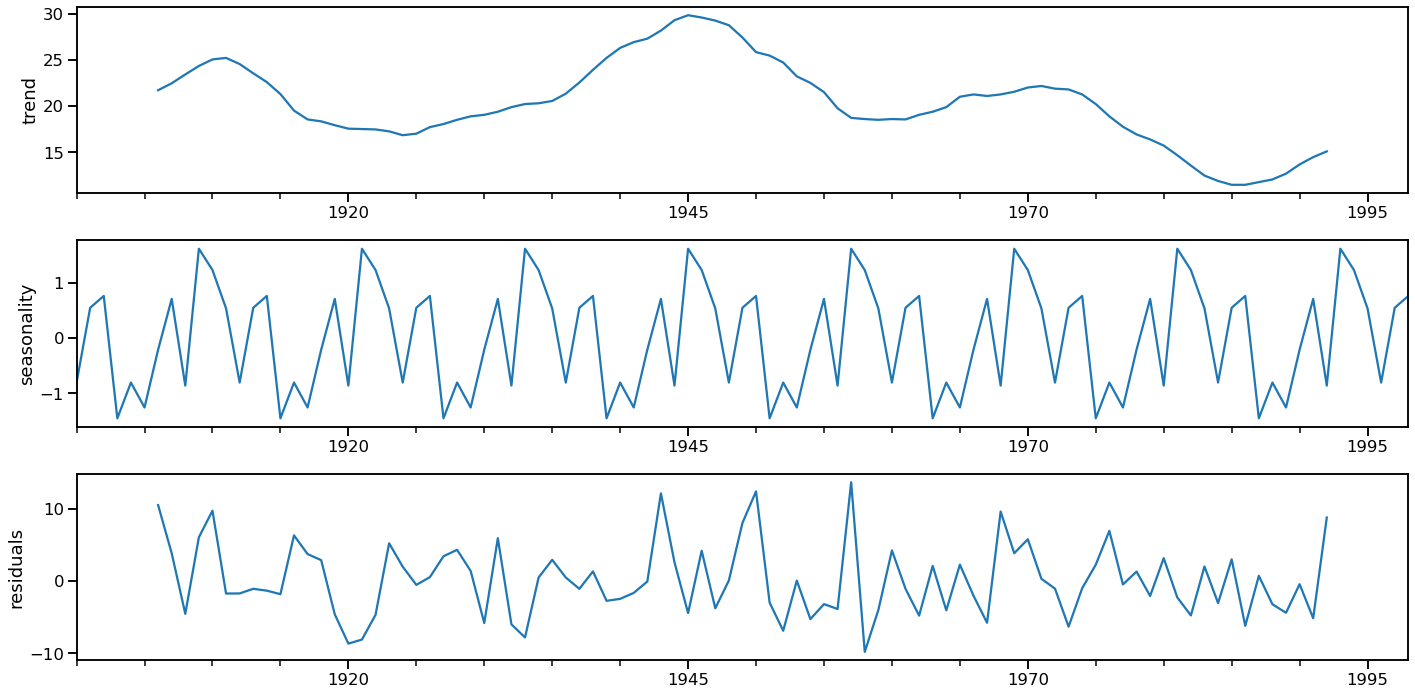

In [414]:
# Plot and show the time series
df.plot(figsize=(20,3))
plt.title("Time series of the number of major earthquakes \n of magnitude 7.0 or greater per year")
plt.xlabel("Year")
plt.ylabel("number of major earthquakes")
plt.yticks(np.arange(0, df['earthquakes_per_year'].max(), 5).tolist())
plt.show()

decomp = seasonal_decompose(df['earthquakes_per_year'], freq=10)

# seasonal components
decomposition = seasonal_decompose(df, freq=12)

plt.subplot(3,1,1)
decomposition.trend.plot(figsize=(20,10))
plt.xlabel("")
plt.ylabel("trend")

plt.subplot(3,1,2)
decomposition.seasonal.plot(figsize=(20,10))
plt.xlabel("")
plt.ylabel("seasonality")

plt.subplot(3,1,3)
decomposition.resid.plot(figsize=(20,10))
plt.xlabel("")
plt.ylabel("residuals")

plt.tight_layout()
plt.show()

#### Dataset statistics

In [415]:
display(df.describe())

,earthquakes_per_year
count,99.000000
mean,20.020202
std,7.263242
min,6.000000
25%,15.000000
50%,20.000000
75%,24.000000
max,41.000000


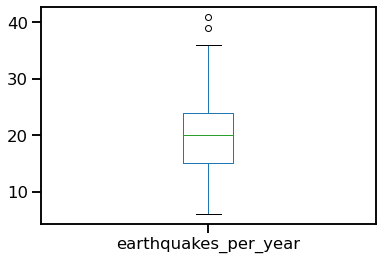

In [416]:
df.plot(kind='box')
plt.show()

#### Is it stationary?
Identifying whether a time series is stationary or non-stationary is very important. If it is stationary we can use ARMA models to predict the next values of the time series. If it is non-stationary then we can't use ARMA models. 

#### Augmented Dicky-Fuller test
1. Tests for trend non-stationarity
2. The null hypothesis is **time series is non-stationary**

<br>if p-value<0.05, reject the null hypothesis = given time series is stationary
<br>if p-value>0.05, can't reject the null hypothesis = given time series is non-stationary

test statistic: more negative means more likely to be stationary

Critical values of the test statistic which equate to different p-values

If it were not stationary this would mean that the number of earthquakes per year has a trend and is changing. This would be terrible news if it is trending upwards, as it means more damage. It would also be terrible news if it were trending downwards, it might suggest the core of our planet is changing and this could have lots of knock on effects for us!

In [417]:
# Run test
Dicky_Fuller_test = adfuller(df['earthquakes_per_year'])

# Print test statistic
test_statistic = Dicky_Fuller_test[0]
print("test statistic = ", test_statistic)

# Print p-value
p_value = Dicky_Fuller_test[1]
print("p-value = ", p_value)

# Print critical values
critical_values = Dicky_Fuller_test[4]
print("critical test statistics = ", critical_values) 

test statistic =  -3.1831922511917816
p-value =  0.020978425256003668
critical test statistics =  {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}


Here, the p-value of the earthquakes_per_year time series is < 0.05, that means we can reject the null hypothesis that the time series is non-stationary. Therefore it is stationary. 

In this case, if we wanted a p-value of 0.05 or below, our test statistic needed to be below -2.89 

#### Transforming non-stationary to stationary time series
However, often it's possible to transform non-stationary time series to stationary ones.
1. Taking the difference
2. Taking the log
3. Taking the square root
4. Taking the proportional change

#### Auto-correlation and Partial Auto-correlation
ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values.

PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

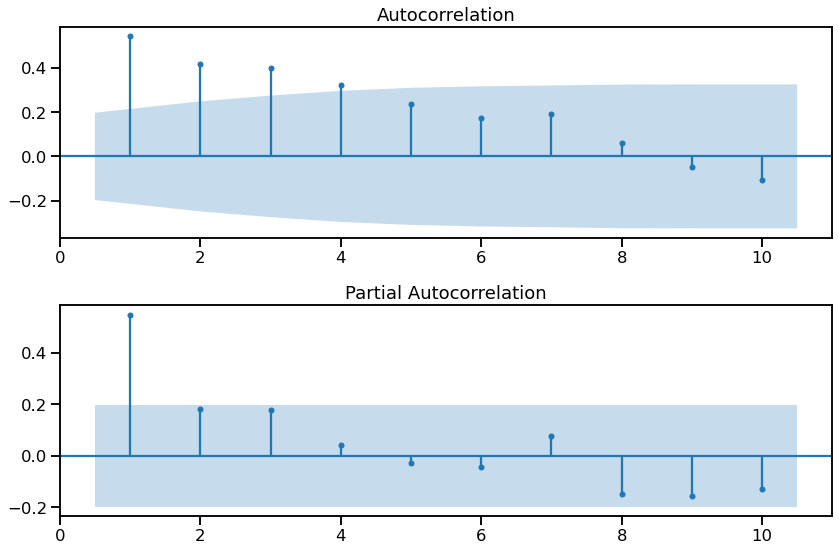

In [418]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df
plot_acf(df['earthquakes_per_year'], lags=10, zero=False, ax=ax1)

# Plot the PACF of df
plot_pacf(df['earthquakes_per_year'], lags=10, zero=False, ax=ax2)

plt.tight_layout()
plt.show()

In [419]:
train, test = model_selection.train_test_split(df, train_size=0.8)

#### How to choose the order of the ARMA model?
By comparing the ACF and PACF for a time series, we can deduce the model order. 
- If the amplitude of the ACF tails off with increasing lag and the PACF cuts off after some lag p, then we have a AR(p) model. 
- If the amplitude of the ACF cuts off after some lag q and the amplitude of the PACF tails off, then we have a MA(q) model. 
- If both the ACF and PACF tail off then we have an ARMA model. 
- If the ACF values are high and tail off very very slowly, this is a sign that the data is non-stationary, so it needs to be differenced. 
- If the autocorrelation at lag-1 is very negative this is a sign that we have taken the difference too many times.

Auto regressive (AR) process , a time series is said to be AR when present value of the time series can be obtained using previous values of the same time series i.e the present value is weighted average of its past values. Stock prices and global temperature rise can be thought of as an AR processes.

Moving average (MA) process, a process where the present value of series is defined as a linear combination of past errors. We assume the errors to be independently distributed with the normal distribution.

Here, the amplitude of the ACF tails off with increasing lag and the PACF cuts off after lag 1, then we have a AR(1) model

In [420]:
# Instantiate the model
ARMA_model = ARMA(train, order=(1,0))

# Fit the model
ARMA_results = ARMA_model.fit()

# Print model fit summary
print(ARMA_results.summary())

# Calculate the mean absolute error from residuals
ARMA_MAE = np.mean(np.abs(ARMA_results.resid))

# Print mean absolute error
print("mean absolute error: ", ARMA_MAE)

                               ARMA Model Results                               
Dep. Variable:     earthquakes_per_year   No. Observations:                   79
Model:                       ARMA(1, 0)   Log Likelihood                -255.433
Method:                         css-mle   S.D. of innovations              6.128
Date:                  Sun, 21 Mar 2021   AIC                            516.866
Time:                          17:26:01   BIC                            523.974
Sample:                      01-01-1900   HQIC                           519.713
                           - 01-01-1978                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         21.3250      1.287     16.570      0.000      18.803      23.847
ar.L1.earthquakes_per_year     0.4698      0.099      4.726      0.

In [421]:
# Instantiate the model
# ARMA(1,0) == SARIMAX(1,0,0)
SARIMAX_model = SARIMAX(train, order=(1,0,0))

# Fit the model
SARIMAX_results = SARIMAX_model.fit()

# Print model fit summary
print(SARIMAX_results.summary())

# Calculate the mean absolute error from residuals
SARIMAX_MAE = np.mean(np.abs(SARIMAX_results.resid))

# Print mean absolute error
print("mean absolute error: ", SARIMAX_MAE)

SARIMAX_predictions = SARIMAX_results.get_forecast(steps=test.shape[0])
SARIMAX_pred = SARIMAX_predictions.predicted_mean

                                SARIMAX Results                                 
Dep. Variable:     earthquakes_per_year   No. Observations:                   79
Model:                 SARIMAX(1, 0, 0)   Log Likelihood                -267.424
Date:                  Sun, 21 Mar 2021   AIC                            538.848
Time:                          17:26:01   BIC                            543.587
Sample:                      01-01-1900   HQIC                           540.746
                           - 01-01-1978                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9449      0.032     29.944      0.000       0.883       1.007
sigma2        49.6033      6.556      7.566      0.000      36.753      62.453
Ljung-Box (L1) (Q):                 

#### AIC - Akaike information criterion
- It tells us how good a model is. Lower AIC indicates a better model.
- AIC likes to choose simple models with lower order. AIC penalizes models which have lots of parameters. This means if we set the order too high compared to the data, we will get a high AIC value.

#### BIC - Bayesian information criterion
- Lower BIC indicates a better model. Model which fit the data better have lower BIC.
- BIC likes to choose simple models with lower order. BIC penalizes overly complex models which has additional model orders.

#### What's the difference between AIC and BIC?
The difference between these two metrics is how much they penalize model complexity.
- BIC favors simpler models than AIC. 
- AIC is better at choosing predictive model
- BIC is better at choosing good explanatory model

#### Ljung-Box Test
**Prob(Q):** p-value for null hypothesis that residuals are uncorrelated
<br>if p-value < 0.05, reject the null hypothesis, that means the residuals are correlated
<br>if p-value > 0.05, can't reject the null hypothesis, that means the residuals are uncorrelated

#### Jarque-Bera Test
**Prob (JB):** p-value for null hypothesis that residuals are normal
<br>if p-value < 0.05, reject the null hypothesis, that means the residuals are not normal
<br>if p-value > 0.05, can't reject the null hypothesis, that means the residuals are normal

#### What are residuals?
The residuals are the difference between the model's one step ahead predictions and the real values of the time series. 

#### Plot Diagnostics: 
- **Standardized Residual plot:** For an ideal model, the residuals should be uncorrelated white Gaussian noise centered on zero. If the model is working correctly, there should be no obvious structure in the residuals. 
- **Histogram plus kde estimate:** The KDE curve should be very similar to the normal distribution
- **Normal Q-Q plot:** If the residuals are normally distributed then all points should lie along the red line, except perhaps some values at either end.
- **Correlogram:** 95% of the correlations for lag greater than zero should not be significant. If there is significant correlation in the residuals, it means that there is information in the data that our model hasn't capture. 

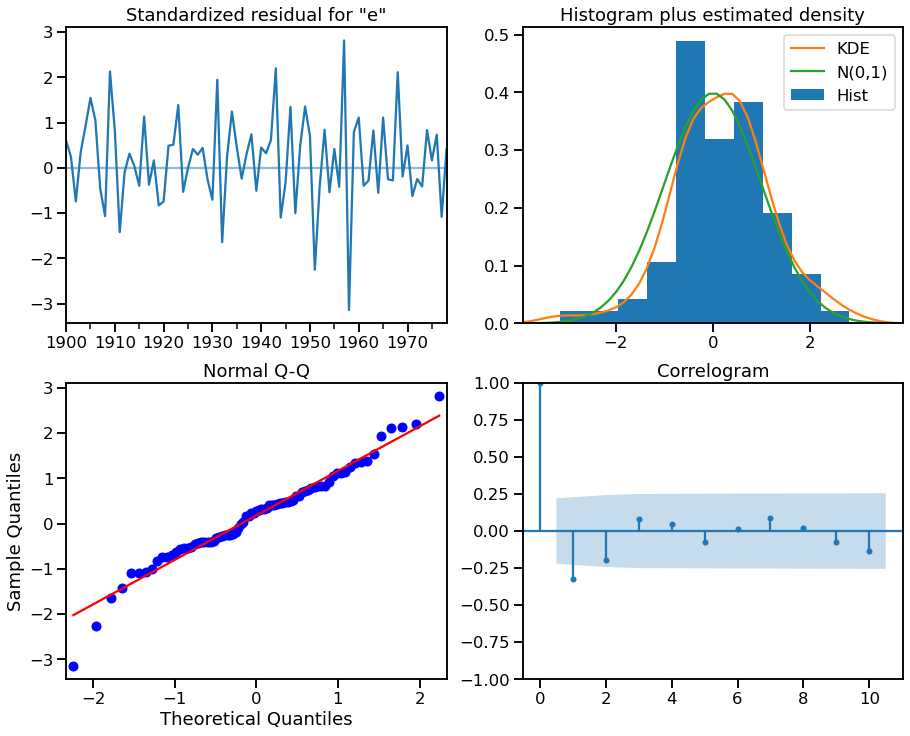

In [422]:
SARIMAX_results.plot_diagnostics(figsize=(15,12))
plt.show()

#### SARIMAX grid search

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[10]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,1,0)[10]             : AIC=522.229, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[10]             : AIC=499.187, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[10]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[10]             : AIC=516.764, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[10]             : AIC=492.273, Time=0.18 sec
 ARIMA(1,1,0)(2,1,1)[10]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,0)(1,1,1)[10]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(2,1,0)[10]             : AIC=497.881, Time=0.07 sec
 ARIMA(2,1,0)(2,1,0)[10]             : AIC=484.128, Time=0.14 sec
 ARIMA(2,1,0)(1,1,0)[10]             : AIC=489.636, Time=0.08 sec
 ARIMA(2,1,0)(2,1,1)[10]             : AIC=inf, Time=0.57 sec
 ARIMA(2,1,0)(1,1,1)[10]             : AIC=inf, Time=0.29 sec
 ARIMA(3,1,0)(2,1,0)[10]             : AIC=484.477, Time=0.16 sec
 ARIMA(2,1,1)(2,1,0)[10]             : AIC=484.122, Time=

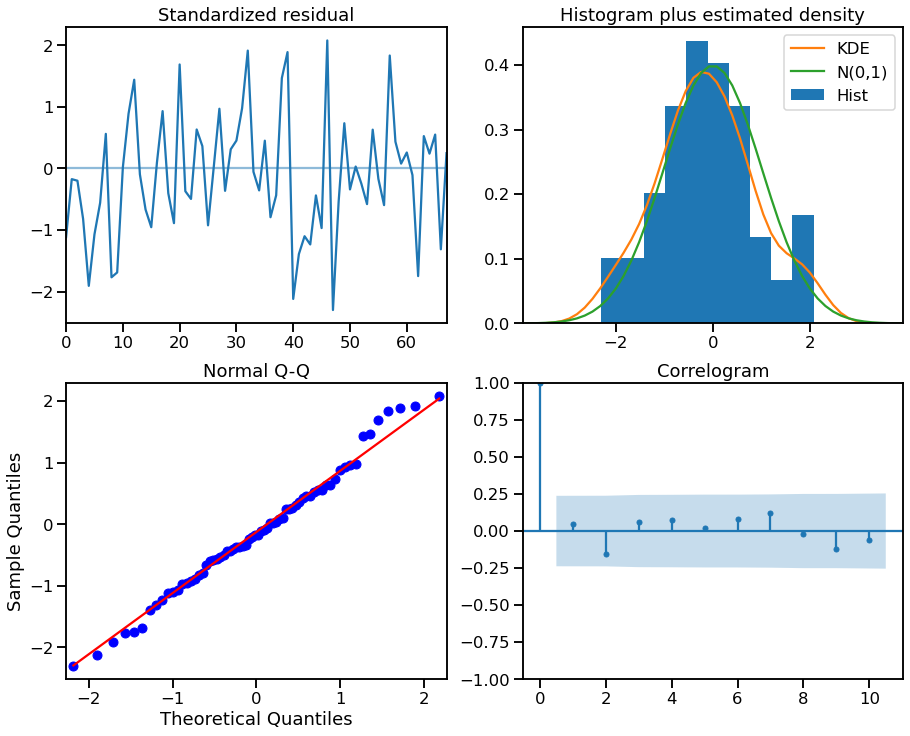

In [423]:
# Create auto_arima SARIMAX(p,d,q)(P,D,Q)m
auto_arima_model = pm.auto_arima(train,
                        seasonal=True,                 # is the time series seasonal?
                        m=10,                          # the seasonal period
                        d=1,                           # trend difference order
                        D=1,                           # seasonal difference order
                        max_p=3,                       # max value of AR(p)
                        max_q=3,                       # max value of MA(q)
                        max_P=2,                       # max value of seasonal AR(P)
                        max_Q=1,                       # max value of seasonal MA(Q)
                        trace=True,                    # print results while training
                        error_action='ignore',         # ignore orders that don't work
                        suppress_warnings=True,
                        information_criterion = 'aic') # to select the best model
                       
# Print model summary
print(auto_arima_model.summary())

auto_arima_model.plot_diagnostics(figsize=(15,12))
plt.show()

#### Saving the model

In [424]:
# Set model name
auto_arima_model_filename = "sarimax_earthquakes.pkl"

# Pickle it
joblib.dump(auto_arima_model, auto_arima_model_filename)

# # load the model
# loaded_model = joblib.load(auto_arima_model_filename)

['sarimax_earthquakes.pkl']

#### Prediction

In [425]:
preds, conf_int = auto_arima_model.predict(n_periods=test.shape[0], return_conf_int=True)

forecast = pd.DataFrame({'earthquakes_per_year': preds,
                        'lower_confidence': conf_int[:,0],
                        'upper_confidence': conf_int[:,1]}, index=test.index)

display(forecast.tail())

,earthquakes_per_year,lower_confidence,upper_confidence
date,,,
1994-01-01,12.519610,-15.857725,40.896945
1995-01-01,16.039965,-13.135925,45.215855
1996-01-01,16.033826,-13.919337,45.986989
1997-01-01,12.179469,-18.531301,42.890239
1998-01-01,17.831711,-13.618421,49.281842


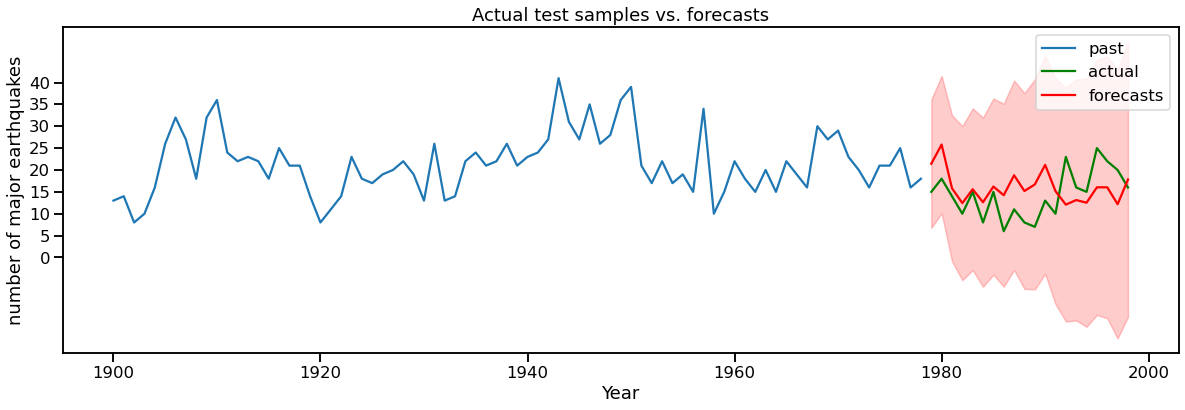

In [426]:
# Plot actual test vs. forecasts:
plt.figure(figsize=(20,6))
plt.plot(train.index, train['earthquakes_per_year'], label='past')
plt.plot(test.index, test['earthquakes_per_year'], label='actual', color='green')
plt.plot(forecast.index, forecast['earthquakes_per_year'], label='forecasts', color='red')
plt.fill_between(forecast.index, conf_int[:,0], conf_int[:,1], alpha=0.2, color='red')

plt.title('Actual test samples vs. forecasts')
plt.xlabel("Year")
plt.ylabel("number of major earthquakes")
plt.yticks(np.arange(0, df['earthquakes_per_year'].max(), 5).tolist())
plt.legend()
plt.show()
plt.show()

In [427]:
auto_arima_MAE = np.round(mean_absolute_error(test['earthquakes_per_year'], forecast['earthquakes_per_year']),2)
print("MAE of Seasonal ARIMA model : ", auto_arima_MAE)

MAE of Seasonal ARIMA model :  5.6
